In [4]:
# use rdkit to generate molecule features while importing dataset
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root='.', name="ESOL")
data

ESOL(1128)

In [6]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len())
print("Dataset sample: ", data[0])
print("Sample nodes: ", data[0].num_nodes)
print("Sample edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  1128
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample nodes:  32
Sample edges:  68


In [7]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

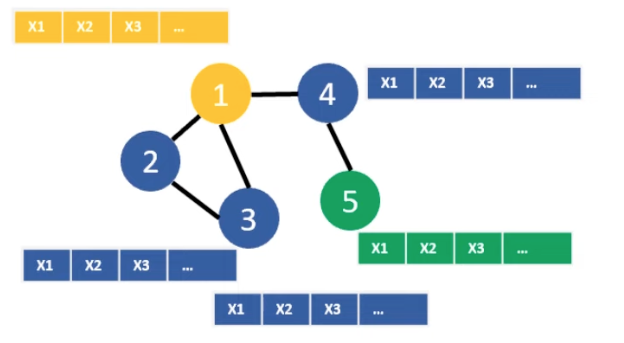

In [10]:
# Investigating the edges in sparse COO format
# Shape: [2, num_edges]
# i.e. node 0 is connected to node 1
# i.e. node 1 is connected to node 0
# i.e. node 1 is connected to node 2
# etc.
# NOTE: more efficient representation than adjacency matrix
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [11]:
data[0].y

tensor([[-0.7700]])

The following problem addresses the predictions based on the graph level. This means we have one y-label for the whole graph. 

Left: graph-level prediction. Right: node-level prediction.

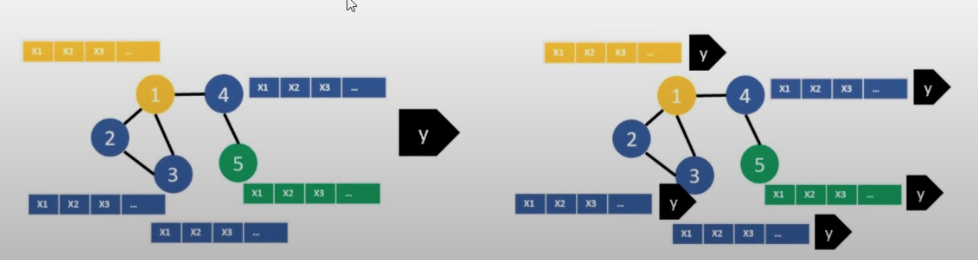

### Converting SMILES to RDKit molecules - Visualizing molecules

In [17]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

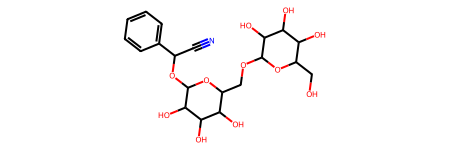

In [18]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [19]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
  def __init__(self):
    # Init parent
    super(GCN, self).__init__()
    torch.manual_seed(197)

    # GCN layers
    self.initial_conv = GCNConv(data.num_features, embedding_size)
    self.conv1 = GCNConv(embedding_size, embedding_size)
    self.conv2 = GCNConv(embedding_size, embedding_size)
    self.conv3 = GCNConv(embedding_size, embedding_size)

    # Output layer
    self.out = Linear(embedding_size*2, data.num_classes) # output shape 1 = regression
    # twice the size for accomodating the global pooling layer

  def forward(self, x, edge_index, batch_index):
    # First Conv layer
    hidden = self.initial_conv(x, edge_index)
    hidden = F.tanh(hidden) # activation function

    # Other Conv layers
    hidden = self.conv1(hidden, edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv2(hidden, edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv3(hidden, edge_index)
    hidden = F.tanh(hidden)

    # Global Pooling Layer (stack different aggregations)
    hidden = torch.cat([gmp(hidden, batch_index), 
                        gap(hidden, batch_index)], dim=1)
    # gmp = global max pooling
    # gap = gloabl average pooling
    # batch_index is used to select the relavent nodes for the pooling operation

    # Apply a final (linear) classifier.
    out = self.out(hidden)

    return out, hidden

In [21]:
model = GCN()
print(model)
print("Model parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=734, bias=True)
)
Model parameters:  107806


/opt/anaconda3/envs/pstat/lib/python3.12/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


### Graph Pooling

Aggregate all information of the final graph

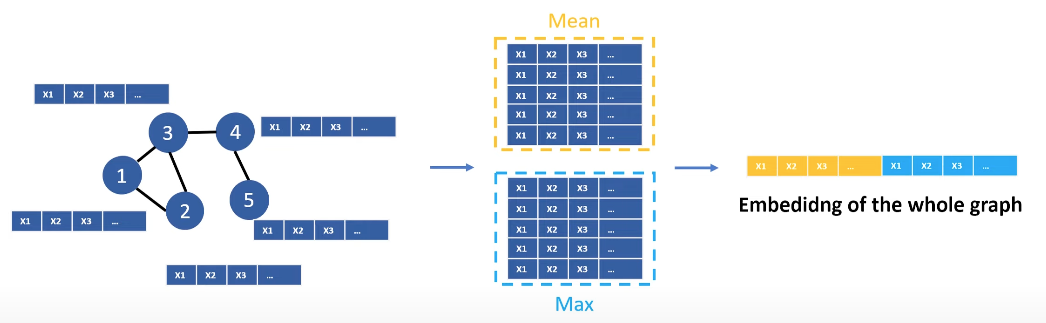

### Training the GNN

In [23]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH,
                    shuffle=True) # 20% training

test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH,
                         shuffle=True) # 80% testing

### Batching with Graphs

Concatenate all node features in a large matrix. Combine each individual adjacency information into a large adjacency matrix or list.

NOTE: each individual graph is disconnected in the adjacency matrix, thus no information is shared between graphs.

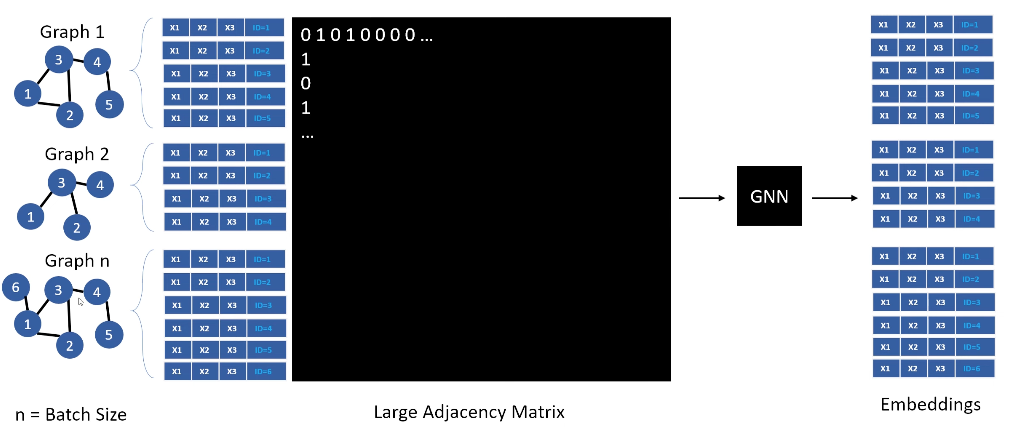

In [24]:
def train(data):
  # Enumerate over the data
  for batch in loader:
    # Use GPU
    batch.to(device)
    # Reset gradients
    optimizer.zero_grad()
    # Passing the node features and the connection info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    # Calculating the loss and gradients
    loss = torch.sqrt(loss_fn(pred, batch.y))
    loss.backward()
    # Update using the gradients
    optimizer.step()
  return loss, embedding

print("Start training...")
losses = []
for epoch in range(2000):
  loss, h = train(data)
  losses.append(loss)
  if epoch % 100 == 0:
    print(f"Epoch {epoch} | Train Loss {loss}")

Start training...
Epoch 0 | Train Loss 2.7871644496917725
Epoch 100 | Train Loss 0.6134768724441528
Epoch 200 | Train Loss 0.6100419163703918
Epoch 300 | Train Loss 0.7272345423698425
Epoch 400 | Train Loss 0.6576130390167236
Epoch 500 | Train Loss 0.2933323383331299
Epoch 600 | Train Loss 0.27025434374809265
Epoch 700 | Train Loss 0.7073735594749451
Epoch 800 | Train Loss 0.3695386052131653
Epoch 900 | Train Loss 0.3794698119163513
Epoch 1000 | Train Loss 0.5742687582969666
Epoch 1100 | Train Loss 0.2634759545326233
Epoch 1200 | Train Loss 0.2466924786567688
Epoch 1300 | Train Loss 0.44479894638061523
Epoch 1400 | Train Loss 0.42036837339401245
Epoch 1500 | Train Loss 0.23418088257312775
Epoch 1600 | Train Loss 0.3676973283290863
Epoch 1700 | Train Loss 0.21275733411312103
Epoch 1800 | Train Loss 0.34913355112075806
Epoch 1900 | Train Loss 0.14146572351455688


### Visualizing the Training Loss

<Axes: >

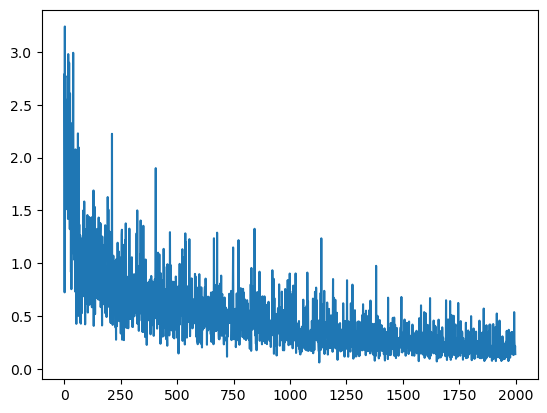

In [27]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i, l in enumerate(losses_float)]
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

### Getting a test prediction

In [28]:
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
  test_batch.to(device)
  pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
  df = pd.DataFrame()
  df["y_real"] = test_batch.y.tolist()
  df["y_pred"] = pred.tolist()

df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-3.79,-3.227950
1,-1.38,-0.949826
2,-2.12,-2.048041
3,-3.30,-3.713397
4,-4.89,-4.858216
...,...,...
59,-2.07,-2.587505
60,0.15,0.918960
61,-3.54,-4.002182
62,-2.54,-2.594413


<Axes: xlabel='y_real', ylabel='y_pred'>

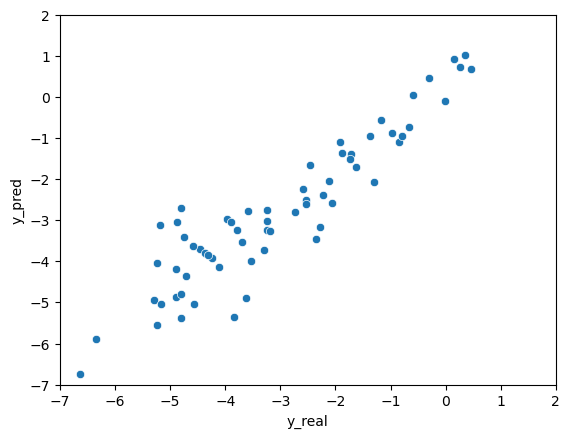

In [29]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

### Improving the model:
- Dropouts
- Other (more intelligent) Pooling Layers
- Global Pooling Layers
- Batch Normalization
- More MP layers
- Other hidden state sizes
- Test metrics (test error) and Hyperparameter optimization
- ...